# Coronavirus Disease (COVID-19) Situation Reports

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-c3ow{border-color:inherit;text-align:center;vertical-align:top}
.tg-sort-header::-moz-selection{background:0 0}
.tg-sort-header::selection{background:0 0}.tg-sort-header{cursor:pointer}
.tg-sort-header:after{content:'';float:right;margin-top:7px;border-width:0 5px 5px;border-style:solid;
  border-color:#404040 transparent;visibility:hidden}
.tg-sort-header:hover:after{visibility:visible}
.tg-sort-asc:after,.tg-sort-asc:hover:after,.tg-sort-desc:after{visibility:visible;opacity:.4}
.tg-sort-desc:after{border-bottom:none;border-width:5px 5px 0}@media screen and (max-width: 767px) {.tg {width: auto !important;}.tg col {width: auto !important;}.tg-wrap {overflow-x: auto;-webkit-overflow-scrolling: touch;}}</style>
<div class="tg-wrap"><table id="tg-5PnCy" class="tg">
<thead>
  <tr>
    <th class="tg-c3ow">Diogo Machado<br></th>
    <th class="tg-c3ow">Gonçalo Marantes</th>
    <th class="tg-c3ow">Leonardo Moura</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-c3ow">Department of Informatics Engineering</td>
    <td class="tg-c3ow">Department of Informatics Engineering</td>
    <td class="tg-c3ow">Department of Informatics Engineering</td>
  </tr>
  <tr>
    <td class="tg-c3ow">Faculty of Engineering of the University of Porto</td>
    <td class="tg-c3ow">Faculty of Engineering of the University of Porto</td>
    <td class="tg-c3ow">Faculty of Engineering of the University of Porto</td>
  </tr>
  <tr>
    <td class="tg-c3ow">diogo.machado@fe.up.pt</td>
    <td class="tg-c3ow">goncalo.marantes@fe.up.pt</td>
    <td class="tg-c3ow">leonardo.moura@fe.up.pt</td>
  </tr>
</tbody>
</table></div>
<script charset="utf-8">var TGSort=window.TGSort||function(n){"use strict";function r(n){return n?n.length:0}function t(n,t,e,o=0){for(e=r(n);o<e;++o)t(n[o],o)}function e(n){return n.split("").reverse().join("")}function o(n){var e=n[0];return t(n,function(n){for(;!n.startsWith(e);)e=e.substring(0,r(e)-1)}),r(e)}function u(n,r,e=[]){return t(n,function(n){r(n)&&e.push(n)}),e}var a=parseFloat;function i(n,r){return function(t){var e="";return t.replace(n,function(n,t,o){return e=t.replace(r,"")+"."+(o||"").substring(1)}),a(e)}}var s=i(/^(?:\s*)([+-]?(?:\d+)(?:,\d{3})*)(\.\d*)?$/g,/,/g),c=i(/^(?:\s*)([+-]?(?:\d+)(?:\.\d{3})*)(,\d*)?$/g,/\./g);function f(n){var t=a(n);return!isNaN(t)&&r(""+t)+1>=r(n)?t:NaN}function d(n){var e=[],o=n;return t([f,s,c],function(u){var a=[],i=[];t(n,function(n,r){r=u(n),a.push(r),r||i.push(n)}),r(i)<r(o)&&(o=i,e=a)}),r(u(o,function(n){return n==o[0]}))==r(o)?e:[]}function v(n){if("TABLE"==n.nodeName){for(var a=function(r){var e,o,u=[],a=[];return function n(r,e){e(r),t(r.childNodes,function(r){n(r,e)})}(n,function(n){"TR"==(o=n.nodeName)?(e=[],u.push(e),a.push(n)):"TD"!=o&&"TH"!=o||e.push(n)}),[u,a]}(),i=a[0],s=a[1],c=r(i),f=c>1&&r(i[0])<r(i[1])?1:0,v=f+1,p=i[f],h=r(p),l=[],g=[],N=[],m=v;m<c;++m){for(var T=0;T<h;++T){r(g)<h&&g.push([]);var C=i[m][T],L=C.textContent||C.innerText||"";g[T].push(L.trim())}N.push(m-v)}t(p,function(n,t){l[t]=0;var a=n.classList;a.add("tg-sort-header"),n.addEventListener("click",function(){var n=l[t];!function(){for(var n=0;n<h;++n){var r=p[n].classList;r.remove("tg-sort-asc"),r.remove("tg-sort-desc"),l[n]=0}}(),(n=1==n?-1:+!n)&&a.add(n>0?"tg-sort-asc":"tg-sort-desc"),l[t]=n;var i,f=g[t],m=function(r,t){return n*f[r].localeCompare(f[t])||n*(r-t)},T=function(n){var t=d(n);if(!r(t)){var u=o(n),a=o(n.map(e));t=d(n.map(function(n){return n.substring(u,r(n)-a)}))}return t}(f);(r(T)||r(T=r(u(i=f.map(Date.parse),isNaN))?[]:i))&&(m=function(r,t){var e=T[r],o=T[t],u=isNaN(e),a=isNaN(o);return u&&a?0:u?-n:a?n:e>o?n:e<o?-n:n*(r-t)});var C,L=N.slice();L.sort(m);for(var E=v;E<c;++E)(C=s[E].parentNode).removeChild(s[E]);for(E=v;E<c;++E)C.appendChild(s[v+L[E-v]])})})}}n.addEventListener("DOMContentLoaded",function(){for(var t=n.getElementsByClassName("tg"),e=0;e<r(t);++e)try{v(t[e])}catch(n){}})}(document)</script>

# Abstract

This project was developed during the course Artificial Intelligence, using *Python* as well as core libraries for Machine Learning projects. These libraries consist of *Pandas*, *PyPlot* and *Seaborn* for data manipulation and visualization, *Scikit-learn* and *Scikit-bio* for machine learning model building. The goal of this project is to build an efficient machine learning model that can classify a country's COVID-19 pandemic curve's current phase based of growth patterns. That being said, using *Pandas* and *Scikit-learn* as main development tools made building an efficient model both simple and straightforward.

---
# Introduction

This project was developed using *Python* and *Jupyter Notebook/Lab* as its development environment during the 3<sup>rd</sup> year course Artificial Intelligence, part of the Integrated Master's Degree in Informatics and Computing Engineering in the Faculty of Engineering of the University of Porto. The main goal of this project is to build an efficient machine learning model that can classify a country's COVID-19 pandemic curve's current phase based of growth patterns.

This notebook has the following structure:

 - **Problem Description:** detailed problem description as a machine learning problem.
 - **Available Data:** investigation and data exploration
 - **Approach:** necessary steps to build the desired model
     - **Data Manipulation:** chosen dataset exploration to best fit our needs
     - **Unsupervised Learning:** data labeling
     - **Supervised Learning:** model training and testing
 - **Experimental Evaluation:** comparison of different models
 - **Conclusion and Future Work:** conclusions taken from the project
 - **References:** books, articles and web pages consulted to develop this project

# Problem Description

Epidemic curves are a statistical chart to visualise the onset of a disease outbreak, and generally show the frequency of new cases compared to the date of disease onset. Also it can generally be broken down into three parts: a start (phase one), a middle (phase two) and and end (phase three).

![covid_pahes](img/curve_phases.jpg)

We intend to group each country's curves into three clusters based on their similarity as a way of labeling these curves based on their current phase.

After having our labeled data our goal is to build a model with this newly labeled data in order to classify in which phase other new curves may be at.

# Available Data

To our advantage there are many available datasets with information regarding the COVID-19 pandemic in different countries. There are even government official data which is available online, including data from Portugal through the National Health Board [website](https://covid19.min-saude.pt/disponibilizacao-de-dados/). After having explored the available resources we settled on using the [COVID-19 Dataset](https://www.kaggle.com/imdevskp/corona-virus-report) from Kaggle. This dataset contains the number of confirmed, death and recovered cases every day across the globe since the 22<sup>nd</sup> of January.

# Approach

In this section we will manipulate the chosen data in order to best fit our desired model, organize country pandemic curves into clusters for labeling and finally train and test our model.

## Data Manipulation

Before anything else, we must handle the raw data of the dataset we're using, so as to fit them to the model we want to implement.

### Reading Data

For reading the raw dataset, we used the [*pandas*](https://pandas.pydata.org/) library, as recommended in the class Lectures.

In [1]:
# Defining Global Variables
DATA_FOLDER = 'data'
WORLD_DATA_FILE = 'world-data.csv'

# import the necessary dependencies
import pandas as pd

In order to properly read the dates, we must declare a custom function to parse the input data. (More information [here](https://stackoverflow.com/questions/17465045/can-pandas-automatically-recognize-dates)).

In [2]:
# creating custom date parser (mm/dd/yy)
from datetime import datetime
custom_date_parser = lambda x: datetime.strptime(x, '%m/%d/%y')

We can now read the csv file, in order to import our dataset.

In [3]:
# read csv
covid_world_dataframe = pd.read_csv(f'{DATA_FOLDER}/{WORLD_DATA_FILE}', parse_dates=['Date'], date_parser=custom_date_parser)
covid_world_dataframe.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
0,NaN,Afghanistan,33.0000,65.0000,2020-01-22,0,0,0
1,NaN,Albania,41.1533,20.1683,2020-01-22,0,0,0
2,NaN,Algeria,28.0339,1.6596,2020-01-22,0,0,0
3,NaN,Andorra,42.5063,1.5218,2020-01-22,0,0,0
4,NaN,Angola,-11.2027,17.8739,2020-01-22,0,0,0


### Data Pre-Processing

We can quickly see that the way the data is presented may be problematic for our intent. It is quickly grasped that some countries have data related to provinces or states, however we are only interested in the countries themselves. So let us quickly identify the problems and point out respectful solutions.

#### Problems

- Some Countries do not have a `Province/State`
- Those that have a `Province/State` also present different `Lat` and `Long` coordinates
- Countries that have a `Province/State` also have the data for `Confirmed`, `Deaths` and `Recovered` for that specific `Province/State`

#### Solution


- Drop the `Province/State` column and group the data by `Country/Region` and `Date`
- Calculate the average `Lat` and `Long` values for each `Country/Region` in the same `Date`
- Calculate the sum of `Confirmed`, `Deaths` and `Recovered` values for each `Country/Region` in the same `Date`

In [4]:
# remove 'Province/State' column
covid_world_dataframe = covid_world_dataframe.drop(labels=['Province/State'], axis=1)
covid_world_dataframe.head()

,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
0,Afghanistan,33.0000,65.0000,2020-01-22,0,0,0
1,Albania,41.1533,20.1683,2020-01-22,0,0,0
2,Algeria,28.0339,1.6596,2020-01-22,0,0,0
3,Andorra,42.5063,1.5218,2020-01-22,0,0,0
4,Angola,-11.2027,17.8739,2020-01-22,0,0,0


In [5]:
# Calculate new 'Lat', 'Long', 'Confirmed', 'Deaths', 'Recovered'
aggregation_functions = {
    # Calculate the average latitude and longitude
    'Lat': 'mean',
    'Long': 'mean',
    # Calculate the sum of confirmed cases, deaths and recovered of the day
    'Confirmed': 'sum',
    'Deaths': 'sum',
    'Recovered': 'sum'
}
# group by country and date
covid_world_dataframe = covid_world_dataframe.groupby(['Date', 'Country/Region']).aggregate(aggregation_functions)
covid_world_dataframe.head()

Lat     Long  Confirmed  Deaths  Recovered
Date       Country/Region                                                
2020-01-22 Afghanistan     33.0000  65.0000          0       0          0
           Albania         41.1533  20.1683          0       0          0
           Algeria         28.0339   1.6596          0       0          0
           Andorra         42.5063   1.5218          0       0          0
           Angola         -11.2027  17.8739          0       0          0

Because of `groupby(['Date', 'Country/Region'])`, the index of the tables is the multi-index `[Date, Country/Region]`. To return to the initial state, we must reset the indices.

In [6]:
covid_world_dataframe = covid_world_dataframe.reset_index()
covid_world_dataframe.head()

,Date,Country/Region,Lat,Long,Confirmed,Deaths,Recovered
0,2020-01-22,Afghanistan,33.0000,65.0000,0,0,0
1,2020-01-22,Albania,41.1533,20.1683,0,0,0
2,2020-01-22,Algeria,28.0339,1.6596,0,0,0
3,2020-01-22,Andorra,42.5063,1.5218,0,0,0
4,2020-01-22,Angola,-11.2027,17.8739,0,0,0


Now our data is presented in the way we initially wanted and is easily manipulated.

### Data Filtering

For demonstration purposes, we will filter the data relative to `China`, `Portugal`, the United States (`US`) and the `United Kingdom`.

In [7]:
# filter
countries = ['US', 'United Kingdom', 'China', 'Portugal']
covid_filtered_dataframe = covid_world_dataframe.loc[covid_world_dataframe['Country/Region'].isin(countries)]
covid_filtered_dataframe.head(8)

,Date,Country/Region,Lat,Long,Confirmed,Deaths,Recovered
36,2020-01-22,China,32.828385,111.649082,548,17,28
136,2020-01-22,Portugal,39.399900,-8.224500,0,0,0
174,2020-01-22,US,37.090200,-95.712900,1,0,0
178,2020-01-22,United Kingdom,24.548173,-43.902245,0,0,0
224,2020-01-23,China,32.828385,111.649082,643,18,30
324,2020-01-23,Portugal,39.399900,-8.224500,0,0,0
362,2020-01-23,US,37.090200,-95.712900,1,0,0
366,2020-01-23,United Kingdom,24.548173,-43.902245,0,0,0


### Plotting

With our new filtered data, we will use [`pairplot`](https://seaborn.pydata.org/generated/seaborn.pairplot.html), so as to be able to compare the `Confirmed`, `Deaths` and `Recovered` values.

**Note:** For our plotting, we are using `seaborn`, as `matplotlib` does not handle dates very well (information [here](https://matplotlib.org/3.1.1/gallery/recipes/common_date_problems.html)).

In [8]:
# This line tells the notebook to show plots inside of the notebook
%matplotlib inline

''

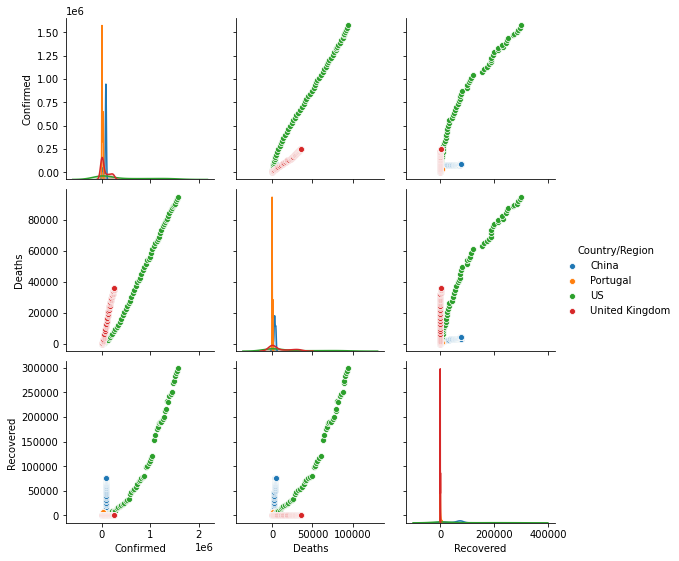

In [9]:
# plot
import matplotlib.pyplot as plt
import seaborn as sb
sb.pairplot(covid_filtered_dataframe, hue='Country/Region', vars=['Confirmed', 'Deaths', 'Recovered'])
;

Let's now compare the data in `Portugal`, over time:

In [10]:
# create portugal dataframe
covid_portugal_dataframe = covid_world_dataframe.loc[covid_world_dataframe['Country/Region'] == 'Portugal']
covid_portugal_dataframe.head()

,Date,Country/Region,Lat,Long,Confirmed,Deaths,Recovered
136,2020-01-22,Portugal,39.3999,-8.2245,0,0,0
324,2020-01-23,Portugal,39.3999,-8.2245,0,0,0
512,2020-01-24,Portugal,39.3999,-8.2245,0,0,0
700,2020-01-25,Portugal,39.3999,-8.2245,0,0,0
888,2020-01-26,Portugal,39.3999,-8.2245,0,0,0


The most direct way to use the dates as the horizontal axis is to simply make them an index, which makes sense, as the dates are unique for each country.

In [11]:
# set date as index and drop column
covid_portugal_dataframe.set_index('Date', inplace=True, drop=True)
covid_portugal_dataframe.head()

,Country/Region,Lat,Long,Confirmed,Deaths,Recovered
Date,,,,,,
2020-01-22,Portugal,39.3999,-8.2245,0,0,0
2020-01-23,Portugal,39.3999,-8.2245,0,0,0
2020-01-24,Portugal,39.3999,-8.2245,0,0,0
2020-01-25,Portugal,39.3999,-8.2245,0,0,0
2020-01-26,Portugal,39.3999,-8.2245,0,0,0


''

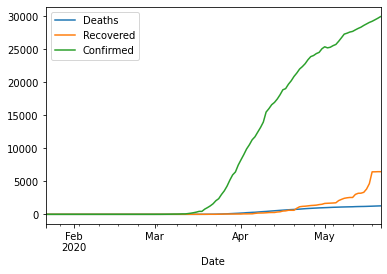

In [12]:
covid_portugal_dataframe[['Deaths', 'Recovered', 'Confirmed']].plot()
;

However, if we explicitly desire to use `seaborn`, which we do, we should reset the index and use the `melt` method:

In [13]:
covid_portugal_dataframe = covid_portugal_dataframe.reset_index()
covid_portugal_dataframe.head()

,Date,Country/Region,Lat,Long,Confirmed,Deaths,Recovered
0,2020-01-22,Portugal,39.3999,-8.2245,0,0,0
1,2020-01-23,Portugal,39.3999,-8.2245,0,0,0
2,2020-01-24,Portugal,39.3999,-8.2245,0,0,0
3,2020-01-25,Portugal,39.3999,-8.2245,0,0,0
4,2020-01-26,Portugal,39.3999,-8.2245,0,0,0


In [129]:
covid_portugal_dataframe_melt = pd.melt(covid_portugal_dataframe, ['Date', 'Country/Region', 'Lat', 'Long'], value_name='Count', var_name='Variable')
covid_portugal_dataframe_melt

,Date,Country/Region,Lat,Long,Variable,Count
0,2020-01-22,Portugal,39.3999,-8.2245,Confirmed,0
1,2020-01-23,Portugal,39.3999,-8.2245,Confirmed,0
2,2020-01-24,Portugal,39.3999,-8.2245,Confirmed,0
3,2020-01-25,Portugal,39.3999,-8.2245,Confirmed,0
4,2020-01-26,Portugal,39.3999,-8.2245,Confirmed,0
...,...,...,...,...,...,...
358,2020-05-17,Portugal,39.3999,-8.2245,Recovered,4636
359,2020-05-18,Portugal,39.3999,-8.2245,Recovered,6430
360,2020-05-19,Portugal,39.3999,-8.2245,Recovered,6431
361,2020-05-20,Portugal,39.3999,-8.2245,Recovered,6452


''

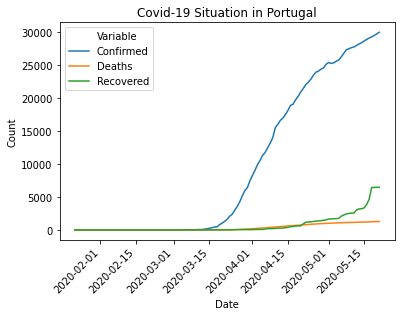

In [130]:
ax = sb.lineplot(x='Date', y='Count', hue='Variable', data=covid_portugal_dataframe_melt)
ax.set_title('Covid-19 Situation in Portugal')
plt.draw()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
;

Let's now compare the data of the 4 countries that were initially filtered:

In [16]:
# create new dataset for chosen countries
confirmed_dataframe = covid_filtered_dataframe[['Date']].copy()
confirmed_dataframe.drop_duplicates(inplace=True)

def get_country_victims(country: str, victims: str):
    return covid_filtered_dataframe.loc[covid_filtered_dataframe['Country/Region'] == country , victims].tolist()

Comparing the confirmed cases between the 4 countries:

In [132]:
confirmed_dataframe['Portugal'] = get_country_victims('Portugal', 'Confirmed')
confirmed_dataframe['US'] = get_country_victims('US', 'Confirmed')
confirmed_dataframe['United Kingdom'] = get_country_victims('United Kingdom', 'Confirmed')
confirmed_dataframe['China'] = get_country_victims('China', 'Confirmed')
confirmed_dataframe

,Date,Portugal,US,United Kingdom,China
36,2020-01-22,0,1,0,548
224,2020-01-23,0,1,0,643
412,2020-01-24,0,2,0,920
600,2020-01-25,0,2,0,1406
788,2020-01-26,0,5,0,2075
...,...,...,...,...,...
21844,2020-05-17,29036,1486757,244995,84054
22032,2020-05-18,29209,1508308,247709,84063
22220,2020-05-19,29432,1528568,250138,84063
22408,2020-05-20,29660,1551853,249619,84063


It's easier to compare the data by visualizing it graphically. Therefore we can draw the plot for the evolution of this variable in the 4 countries:

''

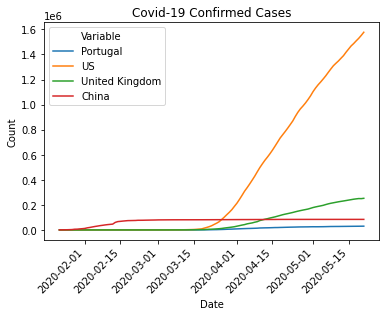

In [134]:
confirmed_dataframe_melt = pd.melt(confirmed_dataframe, ['Date'], value_name='Count', var_name='Variable')
ax = sb.lineplot(x='Date', y='Count', hue='Variable', data=confirmed_dataframe_melt)
ax.set_title('Covid-19 Confirmed Cases')
plt.draw()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
;

Now, let's visualize the cumulative curve of the confirmed cases in these 4 countries.

First, we must create the dataframes for the `US`, the `United Kingdom` and `China`, as the dataframe for `Portugal` has already been created.

In [135]:
# create US dataframe
covid_us_dataframe = covid_world_dataframe.loc[covid_world_dataframe['Country/Region'] == 'US']
# create UK dataframe
covid_uk_dataframe = covid_world_dataframe.loc[covid_world_dataframe['Country/Region'] == 'United Kingdom']
# create China dataframe
covid_china_dataframe = covid_world_dataframe.loc[covid_world_dataframe['Country/Region'] == 'China']

''

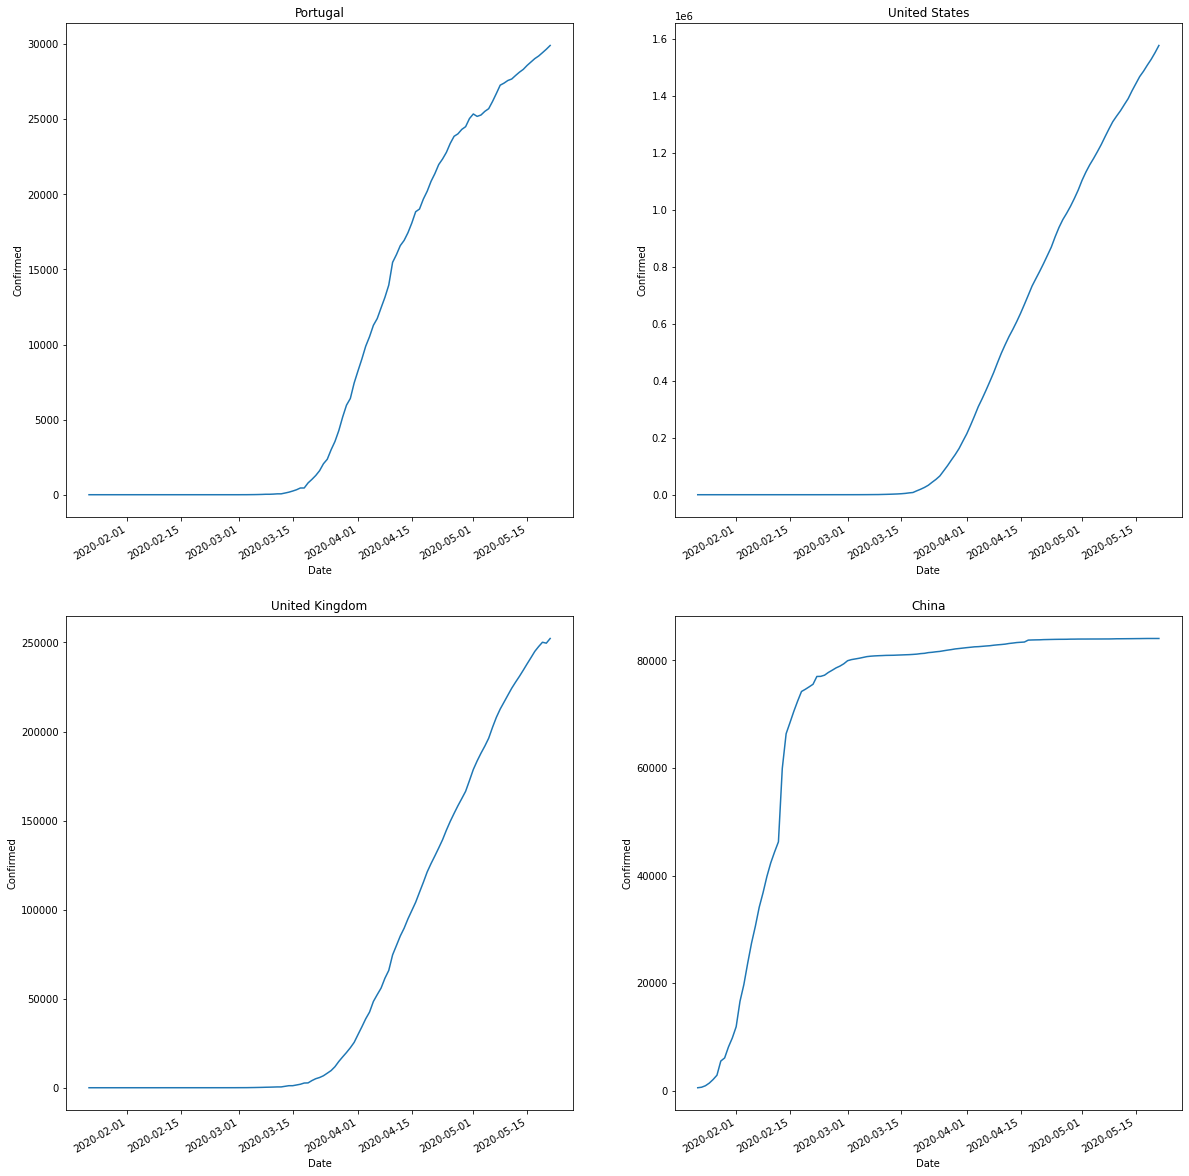

In [139]:
plt.figure(figsize=(20, 20))

plt.subplot(2, 2, 1)
portugal = sb.lineplot(x='Date', y='Confirmed', data=covid_portugal_dataframe)
portugal.set_title('Portugal')
portugal.set_xticklabels(ax.get_xticklabels(), rotation=30, horizontalalignment='right')

plt.subplot(2, 2, 2)
us = sb.lineplot(x='Date', y='Confirmed', data=covid_us_dataframe)
us.set_title('United States')
us.set_xticklabels(ax.get_xticklabels(), rotation=30, horizontalalignment='right')

plt.subplot(2, 2, 3)
uk = sb.lineplot(x='Date', y='Confirmed', data=covid_uk_dataframe)
uk.set_title('United Kingdom')
uk.set_xticklabels(ax.get_xticklabels(), rotation=30, horizontalalignment='right')

plt.subplot(2, 2, 4)
china = sb.lineplot(x='Date', y='Confirmed', data=covid_china_dataframe)
china.set_title('China')
china.set_xticklabels(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
;

This concludes the first section of our project. We can now advance to the implementation of Unsupervised Learning.

--------------------------------------

## Step 2 - Clustering

Regardless of what we have done so far, visual differentiation of these many curves is rather difficult. It is better to classify these curves into clusters, in which similar curves are classified as the same group. Here, we combined **Principle Coordinates Analysis (PCoA)** with **K-Means Clustering**, to plot similarities/relatedness between the incremental patterns of countries/regions, on a 2D referential, and classify them into groups.

In a nutshell, nearby circles (i.e. countries/regions) in 2D ordination should have similar growth patterns, while circles which are far apart share few similarities.

To start things off, let's reverse our dataframe, so that the Countries are now the columns ([source](https://stackoverflow.com/questions/17298313/python-pandas-convert-rows-as-column-headers)):

In [21]:
# we dont need to remove unused columns, pivot_table already does that
'''
# remove lat, long, deaths and recovered
new_dataframe = covid_world_dataframe.drop(labels=['Lat', 'Long', 'Deaths', 'Recovered'], axis=1)
new_dataframe
'''
new_dataframe = covid_world_dataframe.pivot_table(values='Confirmed', index='Date', columns='Country/Region')
new_dataframe

Country/Region,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,...,United Kingdom,Uruguay,Uzbekistan,Venezuela,Vietnam,West Bank and Gaza,Western Sahara,Yemen,Zambia,Zimbabwe
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-22,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0
2020-01-24,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0
2020-01-25,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0
2020-01-26,0,0,0,0,0,0,0,0,4,0,...,0,0,0,0,2,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-17,6664,946,7019,761,48,25,8068,4472,7054,16242,...,244995,734,2753,541,320,381,6,128,753,44
2020-05-18,7072,948,7201,761,50,25,8371,4823,7068,16269,...,247709,737,2791,618,324,388,6,130,761,46
2020-05-19,7653,949,7377,761,52,25,8809,5041,7072,16321,...,250138,738,2855,749,324,391,6,167,772,46


Now, as we can clearly see, we have **121 days** and **188 countries**.

However, as we mentioned before an epidemic curve shows the frequency of new cases compared to the date of disease onset. And at a first glance we can confirm that these numbers as cumulative. Thankfully, [*pandas*](https://pandas.pydata.org/) has built-in [methods](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.diff.html) that allows us to solve that problem.

In [22]:
# store first row
first_row = new_dataframe.iloc[0]
new_dataframe = new_dataframe.diff()
new_dataframe.iloc[0] = first_row
new_dataframe

Country/Region,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,...,United Kingdom,Uruguay,Uzbekistan,Venezuela,Vietnam,West Bank and Gaza,Western Sahara,Yemen,Zambia,Zimbabwe
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
2020-01-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-17,262.0,13.0,198.0,0.0,0.0,0.0,263.0,189.0,10.0,41.0,...,3534.0,1.0,15.0,37.0,2.0,5.0,0.0,6.0,74.0,2.0
2020-05-18,408.0,2.0,182.0,0.0,2.0,0.0,303.0,351.0,14.0,27.0,...,2714.0,3.0,38.0,77.0,4.0,7.0,0.0,2.0,8.0,2.0
2020-05-19,581.0,1.0,176.0,0.0,2.0,0.0,438.0,218.0,4.0,52.0,...,2429.0,1.0,64.0,131.0,0.0,3.0,0.0,37.0,11.0,0.0


We quickly verify a problem with the data. It seems that some countries don't have data for some of the days, as is the case with the `United Kingdom`, in the day `2020-05-20`. We can see this as it is impossible, in differential data, to have negative values, since a confirmed case remains such even after death or recovery.

Our solution is relatively simple: we can replace those negative values, not by the mean, as that would destabilize the daily evolution, but by the average between the previous and following days. For this, we use `interpolate()` ([source](https://pandas.pydata.org/pandas-docs/stable/user_guide/missing_data.html#interpolation)).

In [23]:
import numpy as np

new_dataframe[new_dataframe < 0] = np.nan
new_dataframe = new_dataframe.interpolate()
new_dataframe

Country/Region,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,...,United Kingdom,Uruguay,Uzbekistan,Venezuela,Vietnam,West Bank and Gaza,Western Sahara,Yemen,Zambia,Zimbabwe
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
2020-01-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-17,262.0,13.0,198.0,0.0,0.0,0.0,263.0,189.0,10.0,41.0,...,3534.0,1.0,15.0,37.0,2.0,5.0,0.0,6.0,74.0,2.0
2020-05-18,408.0,2.0,182.0,0.0,2.0,0.0,303.0,351.0,14.0,27.0,...,2714.0,3.0,38.0,77.0,4.0,7.0,0.0,2.0,8.0,2.0
2020-05-19,581.0,1.0,176.0,0.0,2.0,0.0,438.0,218.0,4.0,52.0,...,2429.0,1.0,64.0,131.0,0.0,3.0,0.0,37.0,11.0,0.0


**PCoA** and [**K-Means clustering**](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) for growing pattern:

In [24]:
# Only include coutries with more than 2000 confirmed cases
new_data_thousand = new_dataframe[[i for i in new_dataframe.columns if new_dataframe[i].sum() > 2000]]
new_data_thousand

Country/Region,Afghanistan,Algeria,Argentina,Armenia,Australia,Austria,Azerbaijan,Bahrain,Bangladesh,Belarus,...,Sweden,Switzerland,Tajikistan,Thailand,Turkey,US,Ukraine,United Arab Emirates,United Kingdom,Uzbekistan
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0
2020-01-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0
2020-01-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-26,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-17,262.0,198.0,263.0,189.0,10.0,41.0,136.0,209.0,1273.0,969.0,...,466.0,15.0,202.0,3.0,1368.0,18937.0,433.0,731.0,3534.0,15.0
2020-05-18,408.0,182.0,303.0,351.0,14.0,27.0,113.0,228.0,1602.0,922.0,...,234.0,10.0,205.0,3.0,1158.0,21551.0,325.0,832.0,2714.0,38.0
2020-05-19,581.0,176.0,438.0,218.0,4.0,52.0,131.0,348.0,1251.0,936.0,...,422.0,21.0,207.0,2.0,1022.0,20260.0,260.0,873.0,2429.0,64.0


Since we're only interested in the patterns, the effect of the data size should be diminished. For example, the daily incremental numbers in mainland China are orders higher than that of many other countries. We do not want these differences to be included in our analysis.

The solution for this is to first transform the data as square root, and then to normalize them as numbers in the [0, 1] interval. In doing so, we only catch up the variance in the patterns when calculating similarities between different countries/regions ([source](https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02)).

In [25]:
# Data transformation to reduce the effect of data scale on pattern identification
# Square root transformation
new_data_thousand = new_data_thousand.abs()**0.5
new_data_thousand

Country/Region,Afghanistan,Algeria,Argentina,Armenia,Australia,Austria,Azerbaijan,Bahrain,Bangladesh,Belarus,...,Sweden,Switzerland,Tajikistan,Thailand,Turkey,US,Ukraine,United Arab Emirates,United Kingdom,Uzbekistan
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-22,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.414214,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
2020-01-23,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-24,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.414214,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
2020-01-25,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.414214,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-26,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,1.732051,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-17,16.186414,14.071247,16.217275,13.747727,3.162278,6.403124,11.661904,14.456832,35.679126,31.128765,...,21.587033,3.872983,14.212670,1.732051,36.986484,137.611773,20.808652,27.037012,59.447456,3.872983
2020-05-18,20.199010,13.490738,17.406895,18.734994,3.741657,5.196152,10.630146,15.099669,40.024992,30.364453,...,15.297059,3.162278,14.317821,1.732051,34.029399,146.802589,18.027756,28.844410,52.096065,6.164414
2020-05-19,24.103942,13.266499,20.928450,14.764823,2.000000,7.211103,11.445523,18.654758,35.369478,30.594117,...,20.542639,4.582576,14.387495,1.414214,31.968735,142.337627,16.124515,29.546573,49.284886,8.000000


In [26]:
# Normalisation column-wise
from sklearn import preprocessing

x = new_data_thousand.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
new_data_thousand_norm = pd.DataFrame(x_scaled)
new_data_thousand_norm.columns = new_data_thousand.columns
new_data_thousand_norm

Country/Region,Afghanistan,Algeria,Argentina,Armenia,Australia,Austria,Azerbaijan,Bahrain,Bangladesh,Belarus,...,Sweden,Switzerland,Tajikistan,Thailand,Turkey,US,Ukraine,United Arab Emirates,United Kingdom,Uzbekistan
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.103142,0.000000,0.005257,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.072932,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.103142,0.000000,0.005257,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.103142,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.089712,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.072932,0.000000,0.009105,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,0.671526,0.997484,0.637075,0.733799,0.141848,0.176173,0.927771,0.736788,0.847344,0.807790,...,0.757556,0.106560,0.978441,0.126323,0.515996,0.723391,0.865526,0.881381,0.636138,0.299700
117,0.837996,0.956333,0.683807,1.000000,0.167836,0.142965,0.845689,0.769550,0.950554,0.787956,...,0.536822,0.087006,0.985679,0.126323,0.474742,0.771705,0.749856,0.940301,0.557472,0.477017
118,1.000000,0.940437,0.822147,0.788088,0.089712,0.198404,0.910557,0.950735,0.839990,0.793916,...,0.720905,0.126083,0.990476,0.103142,0.445993,0.748234,0.670691,0.963191,0.527390,0.619059
119,0.920226,0.910574,0.855267,0.809488,0.134568,0.155641,0.845689,0.961600,0.954994,0.786245,...,0.944259,0.174012,0.983272,0.072932,0.434947,0.802150,0.782596,1.000000,0.538030,0.709221


We can visualize the curves for the many countries by running the following commands:

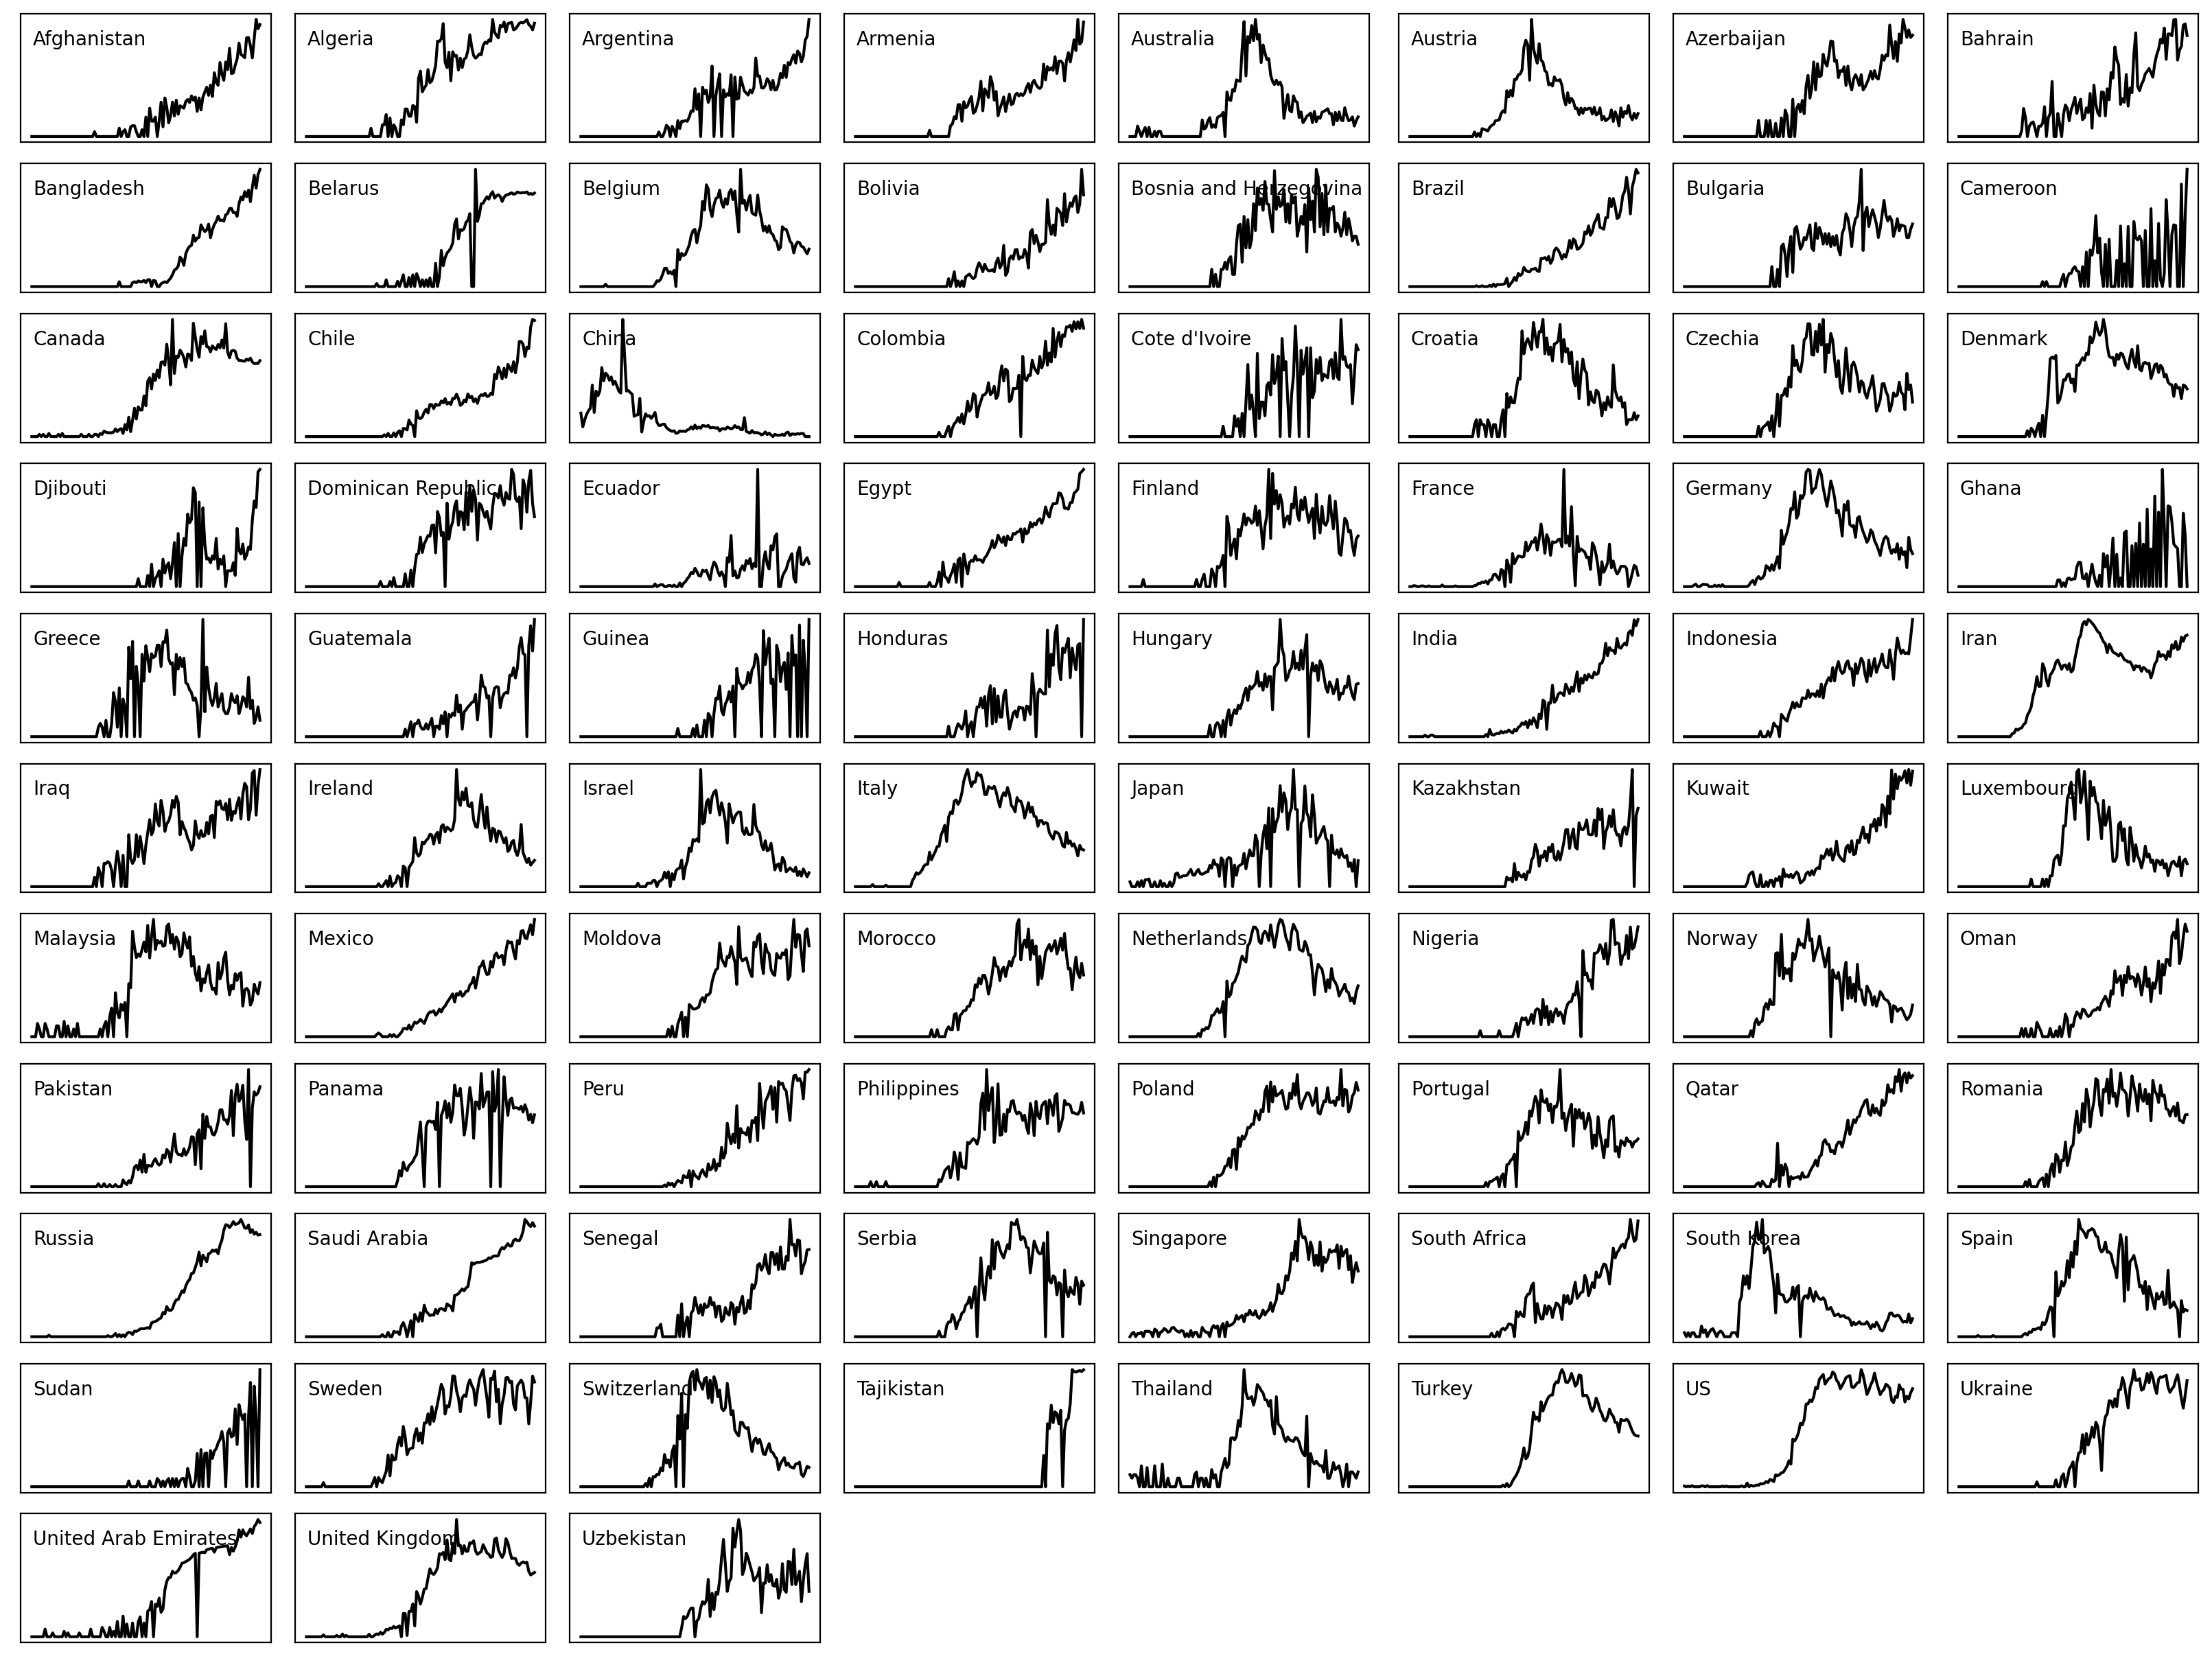

In [66]:
# make plot
fig = plt.figure(figsize=(16,12), dpi=200, constrained_layout=True)

axs = fig.subplots(nrows=11, ncols=8)

for i in range(len(new_data_thousand_norm.columns)):
    # plot column
    axs.flat[i].plot(new_data_thousand_norm.index, new_data_thousand_norm.iloc[:,i], color='black')
    # remove axis labels
    axs.flat[i].get_xaxis().set_ticks([])
    axs.flat[i].get_yaxis().set_ticks([])
    # write contry notation
    axs.flat[i].annotate(new_data_thousand_norm.iloc[:,i].name, (0.05, 0.8),xycoords='axes fraction', va='center', ha='left')
    
# delete unused subplots
num_plots = 11 * 8
num_used_plots = len(new_data_thousand_norm.columns)
for i in range(num_used_plots, num_plots):
    axs.flat[i].set_axis_off()

The Bray Curtis distance/dissimilarity or Sorensen distance is used to **quantify the differences in species populations between two different sites.**
It’s used primarily in ecology and biology, and can be calculated with the following formula:

$$ BC_{ij} = 1 - \frac{2C_{ij}}{S_{i} + S_{j}} $$

where:
 - $i$ and $j$ are the two different sites,
 - $S_{i}$ is the toal number of specimens counted on site $i$
 - $S_{j}$ is the toal number of specimens counted on site $j$,
 - $C_{ij}$ is the sum of only the lesser counts for each of the species found in both sides.

or even:

$$ BC_{ij} = \frac{ \sum_{k=1}^{n} |x_{ik} - x_{jk}|}{ \sum_{k=1}^{n} (x_{ik} + x_{jk}) } $$

where:
 - $x_{ik}$ is the $k^{th}$ specimen of site $i$,
 - $x_{ij}$ is the $k^{th}$ specimen of site $j$.
 
The result for each site is a number between 0 and 1. A value closer to 0 represent similar sites whereas a value closer to 1 means that those two sites are different.

**Note:** In the case of our problem, specifically, the `specimens` and `sites` are, respectively, the days for which we have data, and the countries for which we have data.

In [28]:
def bray_curtis_dissimilarity(table, sample1_id, sample2_id):
    numerator = 0
    denominator = 0
    sample1_counts = table[sample1_id]
    sample2_counts = table[sample2_id]
    for sample1_count, sample2_count in zip(sample1_counts, sample2_counts):
        numerator += abs(sample1_count - sample2_count)
        denominator += sample1_count + sample2_count
    return numerator / denominator

In order to execute the **PCoA**, we must calculate the Bray Curtis Dissimilarity Matrix, which gives us the dissimilarity between each pair of countries.

For that, we are using the external library [Scikit-bio](http://scikit-bio.org/), which contains the data structure [DissimilarityMatrix](http://scikit-bio.org/docs/latest/generated/skbio.stats.distance.html).

In [29]:
from skbio.stats.distance import DissimilarityMatrix
from numpy import zeros

def table_to_dissimilarities(table, pairwise_dissimilarity_fn):
    '''pairwise dissimilarity as a table'''
    sample_ids = table.columns
    num_samples = len(sample_ids)
    data = zeros((num_samples, num_samples))
    for i, sample1_id in enumerate(sample_ids):
        for j, sample2_id in enumerate(sample_ids[:i]):
            data[i,j] = data[j,i] = pairwise_dissimilarity_fn(table, sample1_id, sample2_id)
    return DissimilarityMatrix(data, sample_ids)

We can now produce a Bray-Curtis distance matrix:

In [38]:
# Produce a bray-curtis dissimilarity matrix
bc_dm = table_to_dissimilarities(new_data_thousand_norm, bray_curtis_dissimilarity)
print(bc_dm)

83x83 dissimilarity matrix
IDs:
'Afghanistan', 'Algeria', 'Argentina', 'Armenia', 'Australia', 'Austria', ...
Data:
[[0.         0.31185806 0.18149104 ... 0.23887016 0.31867572 0.2885236 ]
 [0.31185806 0.         0.26442997 ... 0.13610413 0.12701846 0.26980996]
 [0.18149104 0.26442997 0.         ... 0.23841033 0.24220027 0.21069067]
 ...
 [0.23887016 0.13610413 0.23841033 ... 0.         0.16596572 0.22758581]
 [0.31867572 0.12701846 0.24220027 ... 0.16596572 0.         0.20223729]
 [0.2885236  0.26980996 0.21069067 ... 0.22758581 0.20223729 0.        ]]


As we are using `scikit-learn`, we have access to an already implemented version of the [**PCA**](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html), which we can apply to our distance matrix.

In [39]:
# Using PCA on distance matrix and keep the first two components
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
projected = pca.fit_transform(bc_dm.data)

In [40]:
# Variance explained by the first two components
print(pca.explained_variance_)

[0.88196282 0.59084856]


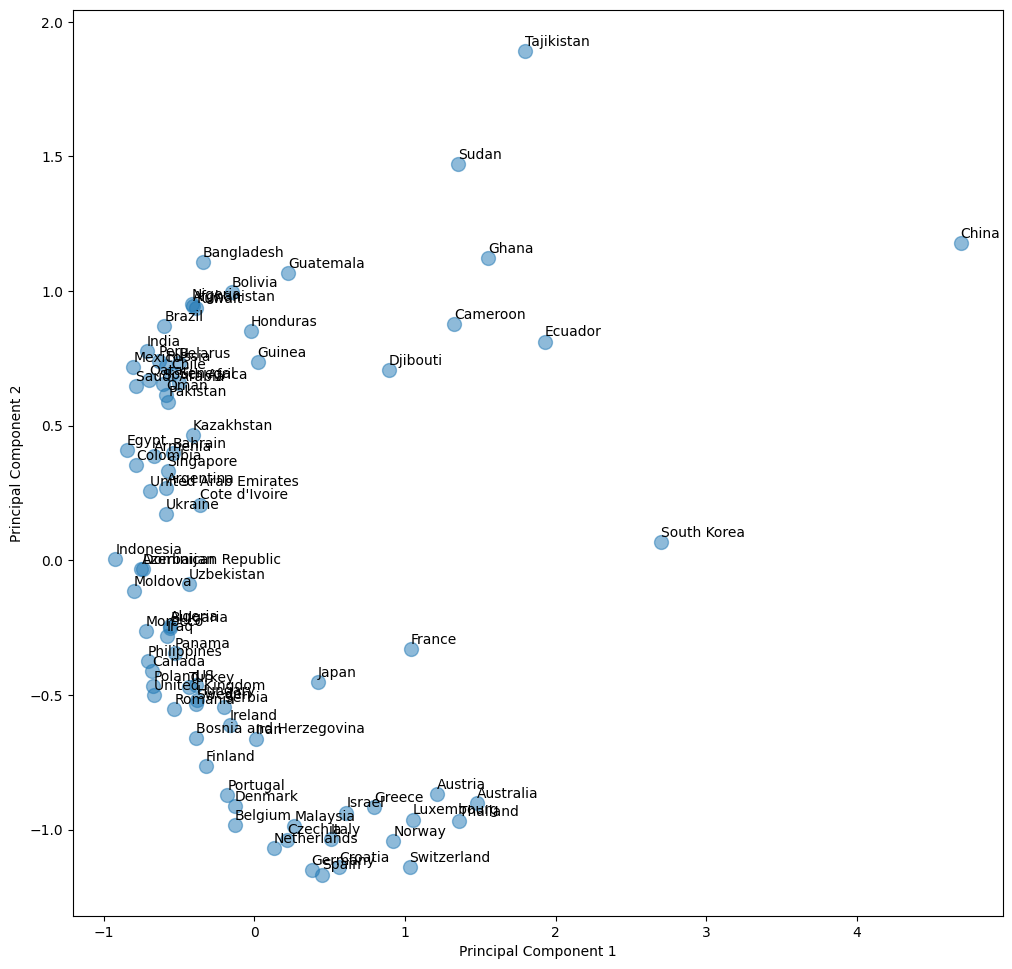

In [41]:
plt.figure(figsize=(12,12), dpi=100)

plt.scatter(projected[:, 0], projected[:, 1], s=100, alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

for i, txt in enumerate(bc_dm.ids):
    plt.annotate(txt, (projected[:, 0][i], projected[:, 1][i]+0.02))

Now, we can cluster the countries by using the `scikit-learn` implementation of [**K-Means Clustering**](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html?highlight=kmeans#sklearn.cluster.KMeans)!

In [60]:
# Cluster countries using K-Means
from sklearn.cluster import KMeans

kmeans = KMeans(init='k-means++', n_clusters=4, random_state=0).fit(projected)
kmeans.labels_

array([0, 3, 0, 0, 1, 1, 3, 0, 0, 0, 3, 0, 3, 0, 3, 2, 3, 0, 2, 0, 0, 1,
       1, 3, 2, 3, 2, 0, 3, 1, 1, 2, 1, 0, 0, 0, 3, 0, 3, 3, 3, 3, 1, 1,
       1, 0, 0, 1, 1, 0, 3, 3, 1, 0, 1, 0, 0, 3, 0, 3, 3, 3, 0, 3, 0, 0,
       0, 3, 0, 0, 2, 1, 2, 3, 1, 2, 1, 3, 3, 0, 0, 3, 3], dtype=int32)

For visual clarity, we shall assign distinct colors to the various clusters:

In [61]:
# Assign color to each cluster
# #d7191c - red
# #2b83ba - blue
# #fdae61 - orange
# #1a9641 - green
color = []
for i in kmeans.labels_:
    if i == 0: # phase 1
        color.append('#fdae61')
    elif i == 1: # phase 3
        color.append('#1a9641')
    elif i == 2: # past phase 3
        color.append('#2b83ba')
    elif i == 3: # phase 2
        color.append('#d7191c')

In [63]:
# Create a metadata table
cluster_data = pd.DataFrame({'Cluster':kmeans.labels_,
                            'Country':bc_dm.ids,
                            'Color':color,
                            'Confirmed':[new_data_thousand[i].sum() for i in bc_dm.ids],
                            'PC1':projected[:, 0],
                            'PC2':projected[:, 1],
                           },)
cluster_data

,Cluster,Country,Color,Confirmed,PC1,PC2
0,0,Afghanistan,#fdae61,640.592283,-0.408265,0.944726
1,3,Algeria,#d7191c,706.063429,-0.560218,-0.242782
2,0,Argentina,#fdae61,757.488859,-0.584556,0.268360
3,0,Armenia,#fdae61,572.849497,-0.668066,0.386294
4,1,Australia,#1a9641,622.423164,1.475895,-0.901090
...,...,...,...,...,...,...
78,3,US,#d7191c,10208.504329,-0.386679,-0.462440
79,0,Ukraine,#fdae61,1049.183428,-0.585742,0.171441
80,0,United Arab Emirates,#fdae61,1234.544990,-0.693663,0.258406
81,3,United Kingdom,#d7191c,4100.019336,-0.665400,-0.501316


In [64]:
# Re-assign cluster id as desired order
cluster_data = cluster_data.replace({'Cluster': {0: 7, 1: 6, 2: 5, 3: 4}})
cluster_data = cluster_data.sort_values(by=['Cluster', 'Confirmed'], ascending=False)
cluster_data = cluster_data.reset_index(drop=True)
cluster_data

,Cluster,Country,Color,Confirmed,PC1,PC2
0,7,Russia,#fdae61,3954.846903,-0.586277,0.721148
1,7,Brazil,#fdae61,3921.722626,-0.598895,0.870945
2,7,India,#fdae61,2451.601191,-0.714753,0.776746
3,7,Peru,#fdae61,2314.099240,-0.635528,0.739921
4,7,Saudi Arabia,#fdae61,1854.102248,-0.784917,0.648154
...,...,...,...,...,...,...
78,4,Hungary,#d7191c,479.758891,-0.382311,-0.517944
79,4,Azerbaijan,#d7191c,474.431403,-0.750499,-0.031312
80,4,Uzbekistan,#d7191c,408.330710,-0.434114,-0.086931
81,4,Bulgaria,#d7191c,390.543249,-0.559029,-0.249961


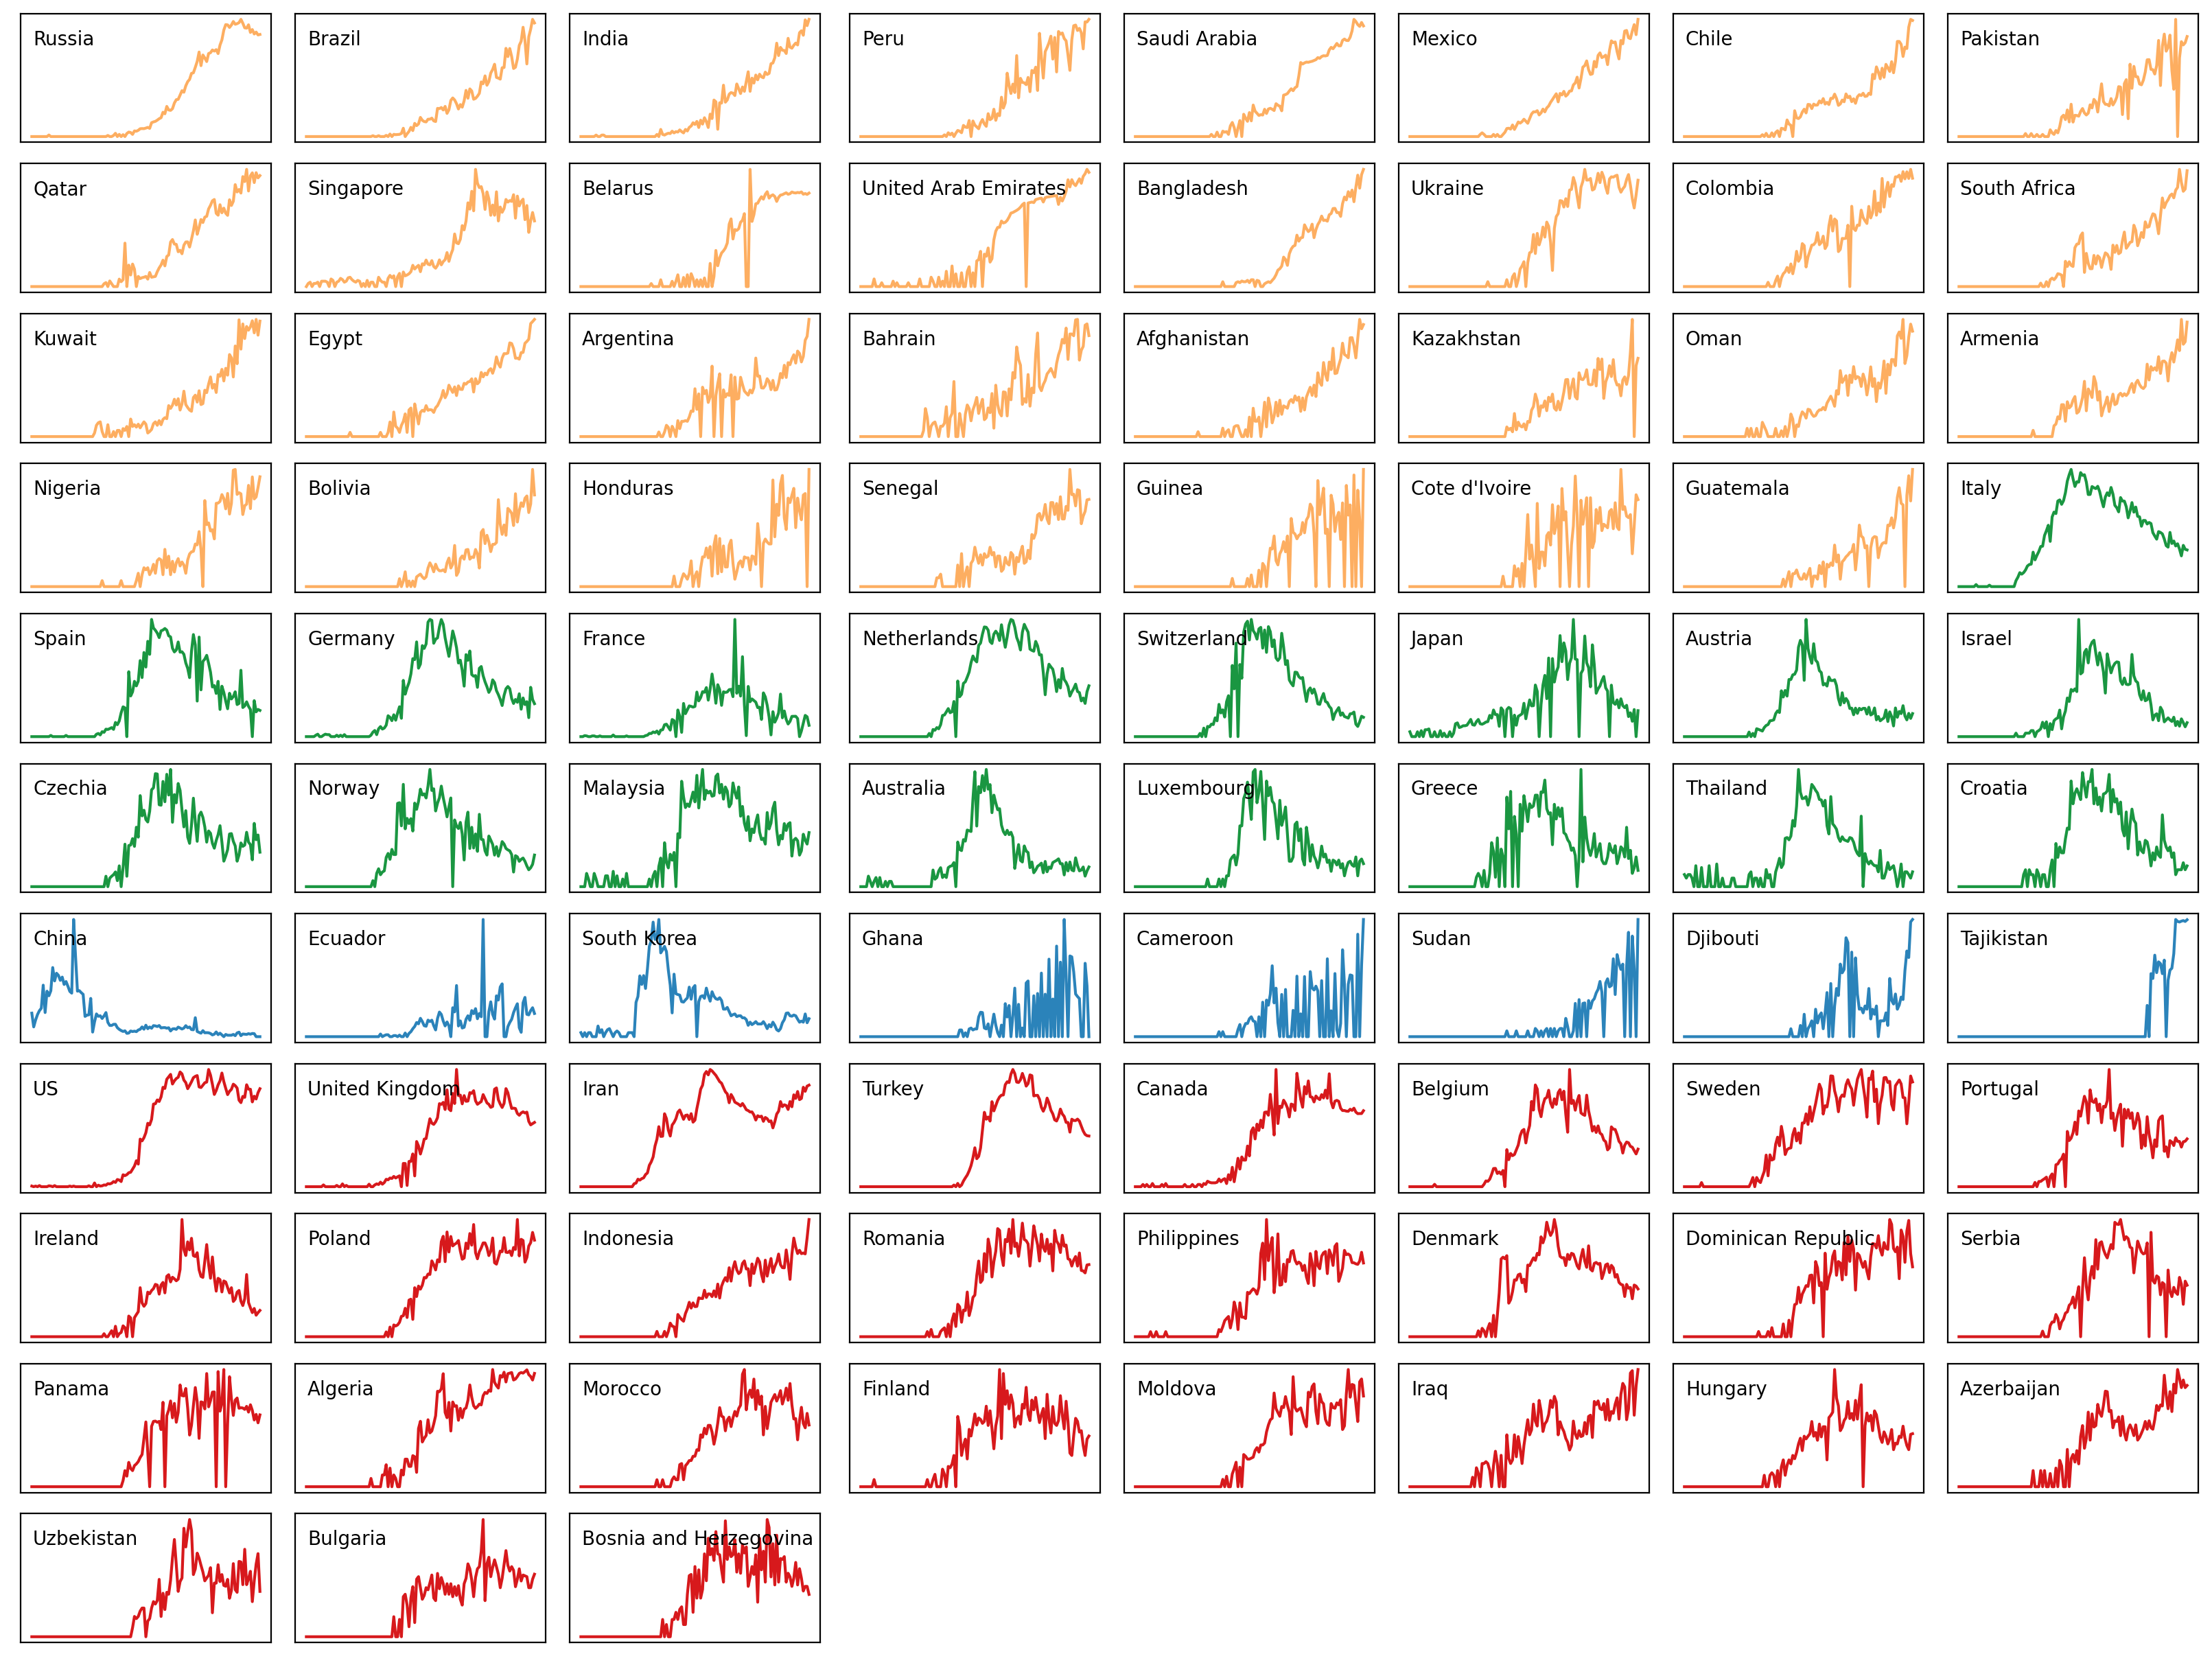

In [67]:
# make plot
fig1 = plt.figure(figsize=(16,12), dpi=200, constrained_layout=True)

axs1 = fig1.subplots(nrows=11, ncols=8)

for order, i in cluster_data.iterrows():          
    axs1.flat[order].plot(new_data_thousand_norm.index, new_data_thousand_norm[i['Country']], color=i['Color'])
    axs1.flat[order].get_xaxis().set_ticks([])
    axs1.flat[order].get_yaxis().set_ticks([])
    axs1.flat[order].annotate(i['Country'], (0.05, 0.8),xycoords='axes fraction', va='center', ha='left')

# delete unused subplots
num_plots = 11 * 8
num_used_plots = cluster_data.shape[0]
for i in range(num_used_plots, num_plots):
    axs1.flat[i].set_axis_off()

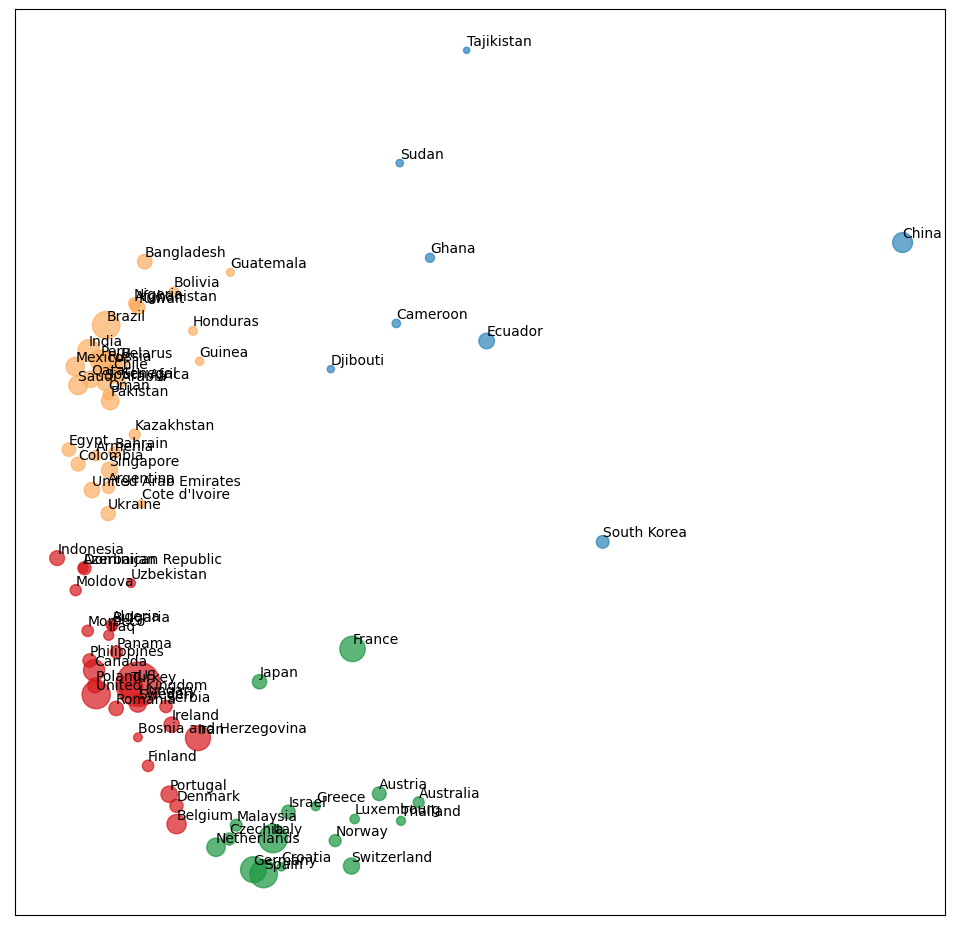

In [89]:
fig3 = plt.figure(figsize=(12,12), dpi=100)
ax1 = fig3.add_subplot()

ax1.scatter(cluster_data['PC1'], cluster_data['PC2'], c=cluster_data['Color'], s=cluster_data['Confirmed']/10, alpha=0.7)
ax1.get_xaxis().set_ticks([])
ax1.get_yaxis().set_ticks([])
#ax1.set_xlabel('PC1({:.2%} variance explaianed)'.format(pca.explained_variance_[0]))
#ax1.set_ylabel('PC2({:.2%} variance explaianed)'.format(pca.explained_variance_[1]))

for i, txt in enumerate(cluster_data['Country']):
    ax1.annotate(txt, (cluster_data['PC1'][i], cluster_data['PC2'][i]+0.02))

### Saving Data

Now that the Unsupervised Learning section of our project is complete, we must save the data obtained. Like so:

In [69]:
saved_cluster_data = cluster_data.drop(labels=['Color', 'PC1', 'PC2', 'Confirmed'], axis=1)
saved_cluster_data.set_index(keys=['Country'])

,Cluster
Country,
Russia,7
Brazil,7
India,7
Peru,7
Saudi Arabia,7
...,...
Hungary,4
Azerbaijan,4
Uzbekistan,4


In [70]:
# save classified countries
saved_cluster_data.set_index(keys=['Country']).to_csv(f'{DATA_FOLDER}/world-class-data.csv')

# save countries and dates
new_data_thousand.transpose().to_csv(f'{DATA_FOLDER}/world-data-simple.csv')

--------------------------------------

## Step 3 - Supervised Learning

Right now, we have access to number of confirmed cases for each country, over time, as well as which cluster each country has been assigned to.

In [71]:
test = new_data_thousand_norm.transpose()
test

,0,1,2,3,4,5,6,7,8,9,...,111,112,113,114,115,116,117,118,119,120
Country/Region,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.689234,0.672806,0.843115,0.844135,0.775041,0.671526,0.837996,1.000000,0.920226,0.956003
Algeria,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.940437,0.966785,0.974551,0.969380,0.982255,0.997484,0.956333,0.940437,0.910574,0.966785
Argentina,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.663185,0.698323,0.627311,0.729663,0.709286,0.637075,0.683807,0.822147,0.855267,1.000000
Armenia,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.644945,0.716115,0.636049,0.724028,0.825174,0.733799,1.000000,0.788088,0.809488,0.976942
Australia,0.000000,0.0,0.000000,0.0,0.089712,0.044856,0.0,0.044856,0.077693,0.000000,...,0.141848,0.134568,0.245687,0.179425,0.134568,0.141848,0.167836,0.089712,0.134568,0.167836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
US,0.005257,0.0,0.005257,0.0,0.009105,0.000000,0.0,0.000000,0.000000,0.007434,...,0.770702,0.762320,0.869639,0.831997,0.831099,0.723391,0.771705,0.748234,0.802150,0.836039
Ukraine,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.805474,0.833967,0.854461,0.914134,0.955769,0.865526,0.749856,0.670691,0.782596,0.907485
United Arab Emirates,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.065198,0.000000,0.000000,...,0.912192,0.877757,0.861257,0.890975,0.919733,0.881381,0.940301,0.963191,1.000000,0.974707


In [72]:
saved_cluster_data

,Cluster,Country
0,7,Russia
1,7,Brazil
2,7,India
3,7,Peru
4,7,Saudi Arabia
...,...,...
78,4,Hungary
79,4,Azerbaijan
80,4,Uzbekistan
81,4,Bulgaria


### 3.1 - Extracting the Data

With this information, we can generate a new dataframe which contains only the cluster a country is assigned to, and the daily evolution of its confirmed cases count, while omitting the name of the country, since it is now irrelevant.

In [73]:
# replace country/region index for cluster id
labeled_data = test.join(saved_cluster_data.set_index('Country')).set_index('Cluster')
labeled_data

,0,1,2,3,4,5,6,7,8,9,...,111,112,113,114,115,116,117,118,119,120
Cluster,,,,,,,,,,,,,,,,,,,,,
7,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.689234,0.672806,0.843115,0.844135,0.775041,0.671526,0.837996,1.000000,0.920226,0.956003
4,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.940437,0.966785,0.974551,0.969380,0.982255,0.997484,0.956333,0.940437,0.910574,0.966785
7,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.663185,0.698323,0.627311,0.729663,0.709286,0.637075,0.683807,0.822147,0.855267,1.000000
7,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.644945,0.716115,0.636049,0.724028,0.825174,0.733799,1.000000,0.788088,0.809488,0.976942
6,0.000000,0.0,0.000000,0.0,0.089712,0.044856,0.0,0.044856,0.077693,0.000000,...,0.141848,0.134568,0.245687,0.179425,0.134568,0.141848,0.167836,0.089712,0.134568,0.167836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,0.005257,0.0,0.005257,0.0,0.009105,0.000000,0.0,0.000000,0.000000,0.007434,...,0.770702,0.762320,0.869639,0.831997,0.831099,0.723391,0.771705,0.748234,0.802150,0.836039
7,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.805474,0.833967,0.854461,0.914134,0.955769,0.865526,0.749856,0.670691,0.782596,0.907485
7,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.065198,0.000000,0.000000,...,0.912192,0.877757,0.861257,0.890975,0.919733,0.881381,0.940301,0.963191,1.000000,0.974707


In [74]:
# extract the data to arrays
all_inputs = labeled_data.values
all_labels = labeled_data.index.to_list()

### 3.2 - Training the Models

Now that our data has been handled to fit our needs and properly extracted, it is ready to be used in the training and testing of the different algorithms we intend on comparing!

In [75]:
from sklearn.model_selection import train_test_split

(training_inputs, testing_inputs, training_classes, testing_classes) \
    = train_test_split(all_inputs, all_labels, test_size=0.25, random_state=1)

from sklearn.tree import DecisionTreeClassifier

# Create the classifier
decision_tree_classifier = DecisionTreeClassifier()

# Train the classifier on the training set
decision_tree_classifier.fit(training_inputs, training_classes)

# Validate the classifier on the testing set using classification accuracy
decision_tree_classifier.score(testing_inputs, testing_classes)

0.7142857142857143

''

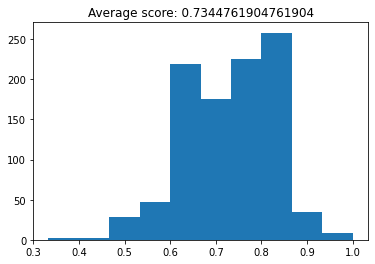

In [76]:
import numpy as np

model_accuracies = []

for repetition in range(1000):
    (training_inputs, testing_inputs,
     training_classes, testing_classes) = train_test_split(all_inputs, all_labels, test_size=0.25)
    
    decision_tree_classifier = DecisionTreeClassifier()
    decision_tree_classifier.fit(training_inputs, training_classes)
    classifier_accuracy = decision_tree_classifier.score(testing_inputs, testing_classes)
    model_accuracies.append(classifier_accuracy)
    
plt.hist(model_accuracies)
plt.title('Average score: {}'.format(np.mean(model_accuracies)))
;

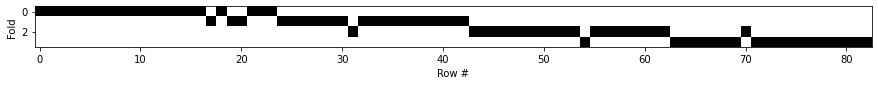

In [100]:
from sklearn.model_selection import StratifiedKFold

def plot_cv(cv, features, labels):
    masks = []
    for train, test in cv.split(features, labels):
        mask = np.zeros(len(labels), dtype=bool)
        mask[test] = 1
        masks.append(mask)
    
    plt.figure(figsize=(15, 15))
    plt.imshow(masks, interpolation='none', cmap='gray_r')
    plt.ylabel('Fold')
    plt.xlabel('Row #')

plot_cv(StratifiedKFold(n_splits=4), all_inputs, all_labels)

''

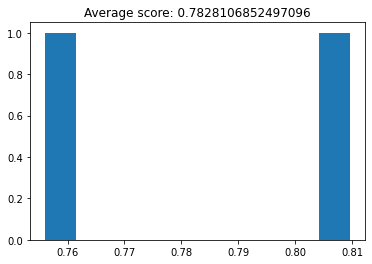

In [104]:
from sklearn.model_selection import cross_val_score

decision_tree_classifier = DecisionTreeClassifier()

# cross_val_score returns a list of the scores, which we can visualize
# to get a reasonable estimate of our classifier's performance
cv_scores = cross_val_score(decision_tree_classifier, all_inputs, all_labels, cv=StratifiedKFold(n_splits=2))
plt.hist(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))
;

In [122]:
from sklearn.model_selection import GridSearchCV

decision_tree_classifier = DecisionTreeClassifier()

parameter_grid = {
    'max_depth': [1, 2, 3, 4, 5],
    'max_features': [1, 2, 3, 4]
}

cross_validation = StratifiedKFold(n_splits=2)

grid_search = GridSearchCV(decision_tree_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation)

grid_search.fit(all_inputs, all_labels)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.8315911730545877
Best parameters: {'max_depth': 3, 'max_features': 4}


''

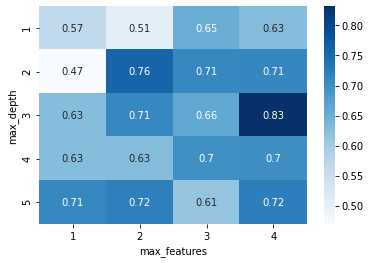

In [123]:
grid_visualization = grid_search.cv_results_['mean_test_score']
grid_visualization.shape = (5, 4)
sb.heatmap(grid_visualization, cmap='Blues', annot=True)
plt.xticks(np.arange(4) + 0.5, grid_search.param_grid['max_features'])
plt.yticks(np.arange(5) + 0.5, grid_search.param_grid['max_depth'])
plt.xlabel('max_features')
plt.ylabel('max_depth')
;

In [124]:
from sklearn.ensemble import RandomForestClassifier

random_forest_classifier = RandomForestClassifier()

parameter_grid = {
    'n_estimators': [10, 25, 50, 100],
    'criterion': ['gini', 'entropy'],
    'max_features': [1, 2, 3, 4]
}

cross_validation = StratifiedKFold(n_splits=2)

grid_search = GridSearchCV(random_forest_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation)

grid_search.fit(all_inputs, all_labels)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

grid_search.best_estimator_

Best score: 0.914924506387921
Best parameters: {'criterion': 'entropy', 'max_features': 2, 'n_estimators': 50}


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features=2,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

''

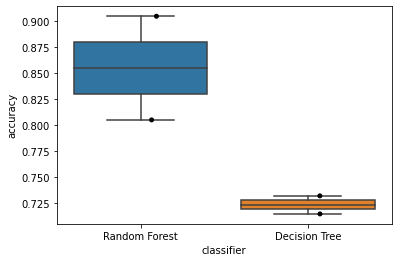

In [125]:
random_forest_classifier = grid_search.best_estimator_

random_forest_dataframe = pd.DataFrame({'accuracy': cross_val_score(random_forest_classifier, all_inputs, all_labels, cv=2),
                       'classifier': ['Random Forest'] * 2})
decision_tree_dataframe = pd.DataFrame({'accuracy': cross_val_score(decision_tree_classifier, all_inputs, all_labels, cv=2),
                      'classifier': ['Decision Tree'] * 2})
both_df = random_forest_dataframe.append(decision_tree_dataframe)

sb.boxplot(x='classifier', y='accuracy', data=both_df)
sb.stripplot(x='classifier', y='accuracy', data=both_df, jitter=True, color='black')
;

---

# References
 - [The three phases of Covid-19 - and how we can make it manageable | The Spinoff](https://thespinoff.co.nz/society/09-03-2020/the-three-phases-of-covid-19-and-how-we-can-make-it-manageable/)
 - [The Continuum of Pandemic Phases - 508 | Pandemic Influenza (Flu) | CDC](https://www.cdc.gov/flu/pandemic-resources/planning-preparedness/global-planning-508.html)
 - [Disponibilização de Dados - COVID-19](https://covid19.min-saude.pt/disponibilizacao-de-dados/)
 - [COVID-19 Dataset | Kaggle](https://www.kaggle.com/imdevskp/corona-virus-report)
 - [pandas - Python Data Analysis Library](https://pandas.pydata.org/)
 - [python - Can pandas automatically recognize dates? - Stack Overflow](https://stackoverflow.com/questions/17465045/can-pandas-automatically-recognize-dates)
 - [Fixing common date annoyances &mdash; Matplotlib 3.1.2 documentation](https://matplotlib.org/3.1.1/gallery/recipes/common_date_problems.html)
 - [Pattern Classification For COVID-19 Growth Data | Towards Data Science](https://towardsdatascience.com/classify-growth-patterns-for-covid-19-data-41af4c7adc55)
 - [data-visualisation-scripts/COVID-19_analysis.ipynb at master &middot; Perishleaf/data-visualisation-scripts](https://github.com/Perishleaf/data-visualisation-scripts/blob/master/coronavirus_country_PCoA/COVID-19_analysis.ipynb)
 - [Python Pandas: Convert Rows as Column headers - Stack Overflow](https://stackoverflow.com/questions/17298313/python-pandas-convert-rows-as-column-headers)
 - [pandas.DataFrame.diff &mdash; pandas 1.0.3 documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.diff.html)
 - [Working with missing data &mdash; pandas 1.0.3 documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/missing_data.html#interpolation)
 - [sklearn.decomposition.PCA &mdash; scikit-learn 0.23.1 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)
 - [sklearn.cluster.KMeans &mdash; scikit-learn 0.23.1 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)
 - [Scale, Standardize or Normalize with Scikit-Learn - Towards Data Science](https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02)
 - [scikit-bio](http://scikit-bio.org/)
 - [Distance matrices and distance-based statistics (skbio.stats.distance) &mdash; scikit-bio 0.5.6 documentation](http://scikit-bio.org/docs/latest/generated/skbio.stats.distance.html)